# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 21 PyTorch CIFAR-10 Custom data loader from scratch

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">

#### References:

- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://www.bountysource.com/issues/44576966-a-tutorial-on-writing-custom-datasets-samplers-and-using-transforms

- https://medium.com/towards-data-science/my-first-kaggle-competition-9d56d4773607

- https://github.com/sohyongsheng/kaggle-planet-forest

- https://github.com/rwightman/pytorch-planet-amazon/blob/master/dataset.py

#### For this to work:
- Download data from https://www.kaggle.com/c/cifar-10/data
- **Remove headers** from the CSV BEFORE running this code
- in the images training folder **copy 1.png to 0.png** and add **the same label** inside training labels. 

- https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/401_CNN.py


# PyTorch Imports


In [41]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.1.12+4eb448a
__CUDA VERSION
__CUDNN VERSION: 5110
__Number CUDA Devices: 0
__Devices


In [42]:
# Torch CPU
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 

! pip install intel-gpu-tools
! pip install snakeviz
! pip install runsnakerun

# python -m cProfile -o out.prof mycode.py

  Could not find a version that satisfies the requirement intel-gpu-tools (from versions: )
No matching distribution found for intel-gpu-tools
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.1, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## CUDA Trick

In [43]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# ! watch -n 1 nvidia-smi
# ! nvidia-smi -l 1

# nvidia-settings -q GPUUtilization -q useddedicatedgpumemory
# You can also use:
#! watch -n0.1 "nvidia-settings -q GPUUtilization -q useddedicatedgpumemory"

# ! pip install git+https://github.com/wookayin/gpustat.git@master
    
# ! watch --color -n1.0 gpustat
# ! gpustat
# ! watch -n 5 nvidia-smi --format=csv --query-gpu=power.draw,utilization.gpu,fan.speed,temperature.gpu

# Setting up global variables

- Root folder
- Image folder
- Image Label folder

In [44]:
! df -k

DATA_ROOT ='/root/data/cifar/'
IMG_PATH = DATA_ROOT + '/train/'
IMG_EXT = '.png'
IMG_DATA_LABELS = DATA_ROOT + '/trainLabels.csv'

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Filesystem     1K-blocks      Used Available Use% Mounted on
none           894819992 226115968 623226752  27% /
tmpfs           32943896         0  32943896   0% /dev
tmpfs           32943896         0  32943896   0% /sys/fs/cgroup
/dev/sda2      894819992 226115968 623226752  27% /root/data
shm                65536      1304     64232   2% /dev/shm
tmpfs           32943896         0  32943896   0% /sys/firmware


# Global parameters

In [45]:
DROPOUT_PROB = 0.85
N_EPOCHS = 50
BATCH_SIZE = 4
LR = 0.005
TEST_RATIO = .22
MOMENTUM= 0.9

PIN_MEMORY=use_cuda # True IF CUDA

# p is the probability of being dropped in PyTorch
dropout = torch.nn.Dropout(p=1 - DROPOUT_PROB)

# fix seed
seed=17*19
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

# The Torch transforms.ToTensor() methood

- Converts: a PIL.Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

In [46]:
transformations = transforms.Compose([transforms.ToTensor()])
# transformations = transforms.Compose([transforms.Scale(32),transforms.ToTensor()])

# transformations=transforms.Compose([transforms.Scale(32),transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                              ])

# transformations=transforms.Compose([transforms.Scale(32), transforms.ToTensor(), # first, convert image to PyTorch tensor
# transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
#                                                           ]) 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# The Torch Dataset Class

In [47]:
try:
    from PIL import Image
except ImportError:
    import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict


class GenericImageDataset(Dataset):    
    def __init__(self, csv_path, img_path, img_ext, tSet=True):                
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))                
        assert img_ext in ['.png']
        
        self.tSet=tSet
        tmp_df = pd.read_csv(csv_path, header=None) # I manually removed the header
        
        self.img_path = img_path
        self.img_ext = img_ext        
        
        # Encoding the variables
        d = defaultdict(LabelEncoder)
        tmp_df = tmp_df.apply(lambda x: d[x.name].fit_transform(x))
        
        lgr.info("DF CSV:\n" + str (tmp_df.head(5)))
            
        self.X_train = tmp_df[0]                
        self.y_train = tmp_df[1]
        
        lgr.info("DF X_train:\n" + str (self.X_train.head(5)))
        lgr.info ("DF y_train:\n" + str(self.y_train.head(5)))        
        lgr.info('[*] Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))

    def __getitem__(self, index):
        
        path=self.img_path + str(self.X_train[index]) + self.img_ext            
        img = Image.open(path)
        if self.tSet==True:
            self.transform=transform_train
        else:
            self.transform=transform_test            
        img = self.transform(img)            
#         label = self.y_train[index]
        label = (self.y_train[index])
#         lgr.info ("__getitem__:" + str(index) + " Label:" + str(label))
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0

In [48]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,
                                 IMG_PATH,
                                 IMG_EXT,tSet=True)

# dset_train = GenericImageDataset(IMG_DATA_LABELS,
#                                  IMG_PATH,
#                                  IMG_EXT,transformations)

INFO:__main__:CSV path /root/data/cifar//trainLabels.csv
INFO:__main__:IMG path /root/data/cifar//train/
INFO:__main__:DF CSV:
   0  1
0  0  6
1  1  6
2  2  9
3  3  9
4  4  4
INFO:__main__:DF X_train:
0    0
1    1
2    2
3    3
4    4
Name: 0, dtype: int64
INFO:__main__:DF y_train:
0    6
1    6
2    9
3    9
4    4
Name: 1, dtype: int64
INFO:__main__:[*] Dataset loading time 0.0440571308136
INFO:__main__:[*] Data size is 50001


# Train Validation Split

- Since there is no train_test_split method in PyTorcj, we have to split a TRAINNING dataset into training and validation sets.

In [49]:
class FullTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainingDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    
def trainTestSplit(dataset, val_share=TEST_RATIO):
    val_offset = int(len(dataset)*(1-val_share))
    return FullTrainingDataset(dataset, 0, val_offset), FullTrainingDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=1,pin_memory=PIN_MEMORY)

val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=1,
                                        pin_memory=PIN_MEMORY)

# Mean and STD

In [50]:
# Test the DataLoader Class

def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

# get_mean_and_std(train_ds)

# ==> Computing mean and std..
# Out[101]:
# (
#   0.4913
#   0.4819
#   0.4459
#  [torch.FloatTensor of size 3], 
#   0.2026
#   0.1996
#   0.2009
#  [torch.FloatTensor of size 3])

# Test the DataLoader Class

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


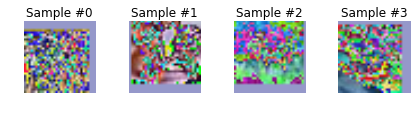

In [51]:
imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


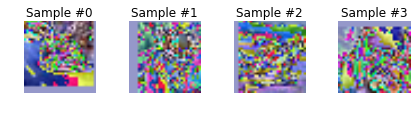

In [52]:
for i, data in enumerate(val_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

# The NN model

###  Initial weights selection

- There are many ways to select the initial weights to a neural network architecture. A common initialization scheme is random initialization, which sets the biases and weights of all the nodes in each hidden layer randomly, so they are in a random point of the space, and objective function, and then find a nearby local minima using an algorithm like SGD or Adam.
- We use a *xavier initializer*, in effect (according to theory) initializing the weights of the network to values that would be closer to the optimal, and therefore require less epochs to train.

### References: 
* **`nninit.xavier_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a uniform distribution.
* **`nninit.xavier_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a normal distribution.
* **`nninit.kaiming_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.](https://arxiv.org/abs/1502.01852) using a uniform distribution.
* **`nninit.kaiming_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.]


In [53]:
class Net(nn.Module):
    def __init__(self,initKernel='uniform'):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
         # xavier initializer
        if initKernel == 'uniform':
            nn.init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
#             nn.init.xavier_uniform(self.conv2.weight, gain=np.sqrt(2.0))
        else:
            nn.init.kaiming_normal(self.conv1.weight)   
#             nn.init.kaiming_normal(self.conv2.weight)   
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x      
    
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(512 * 4, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         h = F.relu(self.conv1(x))
#         h = F.relu(self.conv2(h))
#         h = F.max_pool2d(h, 2)
#         h = F.relu(self.conv3(h))
#         h = F.relu(self.conv4(h))
#         h = F.max_pool2d(h, 2)
#         h = F.relu(self.conv5(h))
#         h = F.relu(self.conv6(h))
#         h = F.max_pool2d(h, 2)

#         h = h.view(-1, 512 * 4)
#         h = F.relu(self.fc1(h))
#         h = F.dropout(h, training=self.training)
#         h = F.log_softmax(self.fc2(h))
#         return h    
    
if use_cuda:
    lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
    lgr.info ("Using the CPU")
    model = Net() # On CPU

lgr.info('Model {}'.format(model))



INFO:__main__:Using the CPU
INFO:__main__:Model Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


#  Loss and Optimizer

- Select a loss function and the optimization algorithm.

- if return F.log_softmax(x) then loss = F.nll_loss(output, target) (MNIST)



In [54]:
# optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class classification
# criterion = nn.CrossEntropyLoss() # Softmax is internally computed.
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# criterion = F.nll_loss()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

lgr.info('Loss function {}'.format(criterion))
lgr.info('Optimizer {}'.format(optimizer))

INFO:__main__:Loss function CrossEntropyLoss (
)
INFO:__main__:Optimizer <torch.optim.sgd.SGD object at 0x7f1525834a90>


# Start training in Batches

See example here:
http://codegists.com/snippet/python/pytorch_mnistpy_kernelmode_python

https://github.com/pytorch/examples/blob/53f25e0d0e2710878449900e1e61d31d34b63a9d/mnist/main.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


loss_history = []
loss_history_2 = []
acc_history = []
running_loss = 0.0

def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader): #  
        # torch.LongTensor of size BATCH_SIZE
        # [torch.FloatTensor of size 4x3x32x32] BATCH_SIZE* IMAGE SIZE
        if use_cuda:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) 
            # You will get RuntimeError: expected CPU tensor (got CUDA tensor) if you dont do this 
        optimizer.zero_grad()        
        outputs = model(data)
        if use_cuda:
            loss = criterion(outputs, target).cuda() 
#             loss = F.nll_loss(outputs, target).cuda() 
             
        else:
            loss = criterion(outputs, target)
#             loss = F.nll_loss(outputs, target) 

        loss.backward()
        optimizer.step()        
        running_loss += loss.data[0]
        if batch_idx % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss / 2000)
            running_loss = 0.0
            
        if batch_idx % 3000 == 0:
            loss_history_2.append(loss.data[0])
            lgr.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))       
            
start_time = time.time()    

for epoch in range(1, N_EPOCHS):
    print("Epoch %d" % epoch)
    train(epoch)    
    print('Finished Training epoch:' + str(epoch))
end_time = time.time()

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

Epoch 1


INFO:__main__:Train Epoch: 1 [0/39000 (0%)]	Loss: 2.259813


[2,     4] loss: 2.065


INFO:__main__:Train Epoch: 1 [12000/39000 (31%)]	Loss: 2.839270


[2,     4] loss: 1.823


INFO:__main__:Train Epoch: 1 [24000/39000 (62%)]	Loss: 1.398095


[2,     4] loss: 1.719
[2,     4] loss: 1.680


INFO:__main__:Train Epoch: 1 [36000/39000 (92%)]	Loss: 1.384702


Finished Training epoch:1
Epoch 2


INFO:__main__:Train Epoch: 2 [0/39000 (0%)]	Loss: 2.281312


[3,     4] loss: 1.597


INFO:__main__:Train Epoch: 2 [12000/39000 (31%)]	Loss: 1.596208


[3,     4] loss: 1.585


INFO:__main__:Train Epoch: 2 [24000/39000 (62%)]	Loss: 1.574419


[3,     4] loss: 1.537
[3,     4] loss: 1.514


INFO:__main__:Train Epoch: 2 [36000/39000 (92%)]	Loss: 1.151519


Finished Training epoch:2
Epoch 3


INFO:__main__:Train Epoch: 3 [0/39000 (0%)]	Loss: 2.068013


[4,     4] loss: 1.469


INFO:__main__:Train Epoch: 3 [12000/39000 (31%)]	Loss: 2.004927


[4,     4] loss: 1.469


INFO:__main__:Train Epoch: 3 [24000/39000 (62%)]	Loss: 1.345932


[4,     4] loss: 1.447
[4,     4] loss: 1.439


INFO:__main__:Train Epoch: 3 [36000/39000 (92%)]	Loss: 1.271816


Finished Training epoch:3
Epoch 4


INFO:__main__:Train Epoch: 4 [0/39000 (0%)]	Loss: 0.892495


[5,     4] loss: 1.389


INFO:__main__:Train Epoch: 4 [12000/39000 (31%)]	Loss: 1.272600


[5,     4] loss: 1.398


INFO:__main__:Train Epoch: 4 [24000/39000 (62%)]	Loss: 1.919976


[5,     4] loss: 1.396
[5,     4] loss: 1.379


INFO:__main__:Train Epoch: 4 [36000/39000 (92%)]	Loss: 1.436019


Finished Training epoch:4
Epoch 5


INFO:__main__:Train Epoch: 5 [0/39000 (0%)]	Loss: 1.759703


[6,     4] loss: 1.368


INFO:__main__:Train Epoch: 5 [12000/39000 (31%)]	Loss: 1.374362


[6,     4] loss: 1.344


INFO:__main__:Train Epoch: 5 [24000/39000 (62%)]	Loss: 1.743422


[6,     4] loss: 1.348
[6,     4] loss: 1.353


INFO:__main__:Train Epoch: 5 [36000/39000 (92%)]	Loss: 1.252129


Finished Training epoch:5
Epoch 6


INFO:__main__:Train Epoch: 6 [0/39000 (0%)]	Loss: 0.448803


[7,     4] loss: 1.320


INFO:__main__:Train Epoch: 6 [12000/39000 (31%)]	Loss: 0.526383


[7,     4] loss: 1.323


INFO:__main__:Train Epoch: 6 [24000/39000 (62%)]	Loss: 1.570933


[7,     4] loss: 1.324
[7,     4] loss: 1.329


INFO:__main__:Train Epoch: 6 [36000/39000 (92%)]	Loss: 1.459506


Finished Training epoch:6
Epoch 7


INFO:__main__:Train Epoch: 7 [0/39000 (0%)]	Loss: 1.966022


[8,     4] loss: 1.296


INFO:__main__:Train Epoch: 7 [12000/39000 (31%)]	Loss: 0.701915


[8,     4] loss: 1.297


INFO:__main__:Train Epoch: 7 [24000/39000 (62%)]	Loss: 0.807866


[8,     4] loss: 1.302
[8,     4] loss: 1.304


INFO:__main__:Train Epoch: 7 [36000/39000 (92%)]	Loss: 1.907610


Finished Training epoch:7
Epoch 8


INFO:__main__:Train Epoch: 8 [0/39000 (0%)]	Loss: 0.989859


[9,     4] loss: 1.289


INFO:__main__:Train Epoch: 8 [12000/39000 (31%)]	Loss: 2.003882


[9,     4] loss: 1.299


INFO:__main__:Train Epoch: 8 [24000/39000 (62%)]	Loss: 0.747941


[9,     4] loss: 1.264
[9,     4] loss: 1.257


INFO:__main__:Train Epoch: 8 [36000/39000 (92%)]	Loss: 1.406976


Finished Training epoch:8
Epoch 9


INFO:__main__:Train Epoch: 9 [0/39000 (0%)]	Loss: 1.297467


[10,     4] loss: 1.249


INFO:__main__:Train Epoch: 9 [12000/39000 (31%)]	Loss: 0.882323


[10,     4] loss: 1.272


INFO:__main__:Train Epoch: 9 [24000/39000 (62%)]	Loss: 1.809573


[10,     4] loss: 1.294
[10,     4] loss: 1.262


INFO:__main__:Train Epoch: 9 [36000/39000 (92%)]	Loss: 2.454279


Finished Training epoch:9
Epoch 10


INFO:__main__:Train Epoch: 10 [0/39000 (0%)]	Loss: 1.548147


[11,     4] loss: 1.261


INFO:__main__:Train Epoch: 10 [12000/39000 (31%)]	Loss: 0.409325


[11,     4] loss: 1.277


INFO:__main__:Train Epoch: 10 [24000/39000 (62%)]	Loss: 1.309832


[11,     4] loss: 1.248
[11,     4] loss: 1.243


INFO:__main__:Train Epoch: 10 [36000/39000 (92%)]	Loss: 1.373882


Finished Training epoch:10
Epoch 11


INFO:__main__:Train Epoch: 11 [0/39000 (0%)]	Loss: 1.655002


[12,     4] loss: 1.249


INFO:__main__:Train Epoch: 11 [12000/39000 (31%)]	Loss: 0.782606


[12,     4] loss: 1.236


INFO:__main__:Train Epoch: 11 [24000/39000 (62%)]	Loss: 1.475798


[12,     4] loss: 1.248
[12,     4] loss: 1.236


INFO:__main__:Train Epoch: 11 [36000/39000 (92%)]	Loss: 1.124254


Finished Training epoch:11
Epoch 12


INFO:__main__:Train Epoch: 12 [0/39000 (0%)]	Loss: 1.313282


[13,     4] loss: 1.207


INFO:__main__:Train Epoch: 12 [12000/39000 (31%)]	Loss: 0.731838


[13,     4] loss: 1.231


INFO:__main__:Train Epoch: 12 [24000/39000 (62%)]	Loss: 0.540180


[13,     4] loss: 1.239
[13,     4] loss: 1.251


INFO:__main__:Train Epoch: 12 [36000/39000 (92%)]	Loss: 1.572639


Finished Training epoch:12
Epoch 13


INFO:__main__:Train Epoch: 13 [0/39000 (0%)]	Loss: 2.475478


[14,     4] loss: 1.217


INFO:__main__:Train Epoch: 13 [12000/39000 (31%)]	Loss: 1.169338


[14,     4] loss: 1.230


INFO:__main__:Train Epoch: 13 [24000/39000 (62%)]	Loss: 0.920745


[14,     4] loss: 1.196
[14,     4] loss: 1.217


INFO:__main__:Train Epoch: 13 [36000/39000 (92%)]	Loss: 1.329586


Finished Training epoch:13
Epoch 14


INFO:__main__:Train Epoch: 14 [0/39000 (0%)]	Loss: 1.415998


[15,     4] loss: 1.223


INFO:__main__:Train Epoch: 14 [12000/39000 (31%)]	Loss: 1.290942


[15,     4] loss: 1.218


INFO:__main__:Train Epoch: 14 [24000/39000 (62%)]	Loss: 0.415455


[15,     4] loss: 1.195
[15,     4] loss: 1.227


INFO:__main__:Train Epoch: 14 [36000/39000 (92%)]	Loss: 0.233751


Finished Training epoch:14
Epoch 15


INFO:__main__:Train Epoch: 15 [0/39000 (0%)]	Loss: 2.069538


[16,     4] loss: 1.207


INFO:__main__:Train Epoch: 15 [12000/39000 (31%)]	Loss: 1.355158


[16,     4] loss: 1.201


INFO:__main__:Train Epoch: 15 [24000/39000 (62%)]	Loss: 2.279980


[16,     4] loss: 1.208
[16,     4] loss: 1.212


INFO:__main__:Train Epoch: 15 [36000/39000 (92%)]	Loss: 1.807873


Finished Training epoch:15
Epoch 16


INFO:__main__:Train Epoch: 16 [0/39000 (0%)]	Loss: 0.636429


[17,     4] loss: 1.192


INFO:__main__:Train Epoch: 16 [12000/39000 (31%)]	Loss: 1.239527


[17,     4] loss: 1.208


INFO:__main__:Train Epoch: 16 [24000/39000 (62%)]	Loss: 0.870721


[17,     4] loss: 1.180
[17,     4] loss: 1.197


INFO:__main__:Train Epoch: 16 [36000/39000 (92%)]	Loss: 0.879048


Finished Training epoch:16
Epoch 17


INFO:__main__:Train Epoch: 17 [0/39000 (0%)]	Loss: 1.221481


[18,     4] loss: 1.190


INFO:__main__:Train Epoch: 17 [12000/39000 (31%)]	Loss: 1.534629


[18,     4] loss: 1.190


INFO:__main__:Train Epoch: 17 [24000/39000 (62%)]	Loss: 0.671552


[18,     4] loss: 1.202
[18,     4] loss: 1.213


INFO:__main__:Train Epoch: 17 [36000/39000 (92%)]	Loss: 2.020502


Finished Training epoch:17
Epoch 18


INFO:__main__:Train Epoch: 18 [0/39000 (0%)]	Loss: 1.684998


[19,     4] loss: 1.174


INFO:__main__:Train Epoch: 18 [12000/39000 (31%)]	Loss: 2.221324


[19,     4] loss: 1.204


INFO:__main__:Train Epoch: 18 [24000/39000 (62%)]	Loss: 1.447802


[19,     4] loss: 1.178
[19,     4] loss: 1.193


INFO:__main__:Train Epoch: 18 [36000/39000 (92%)]	Loss: 0.661578


Finished Training epoch:18
Epoch 19


INFO:__main__:Train Epoch: 19 [0/39000 (0%)]	Loss: 1.862416


[20,     4] loss: 1.177


INFO:__main__:Train Epoch: 19 [12000/39000 (31%)]	Loss: 0.557107


[20,     4] loss: 1.181


INFO:__main__:Train Epoch: 19 [24000/39000 (62%)]	Loss: 0.811033


[20,     4] loss: 1.189
[20,     4] loss: 1.183


INFO:__main__:Train Epoch: 19 [36000/39000 (92%)]	Loss: 0.466718


Finished Training epoch:19
Epoch 20


INFO:__main__:Train Epoch: 20 [0/39000 (0%)]	Loss: 2.507657


[21,     4] loss: 1.170


INFO:__main__:Train Epoch: 20 [12000/39000 (31%)]	Loss: 0.802414


[21,     4] loss: 1.178


INFO:__main__:Train Epoch: 20 [24000/39000 (62%)]	Loss: 1.430140


[21,     4] loss: 1.171
[21,     4] loss: 1.211


INFO:__main__:Train Epoch: 20 [36000/39000 (92%)]	Loss: 0.723025


Finished Training epoch:20
Epoch 21


INFO:__main__:Train Epoch: 21 [0/39000 (0%)]	Loss: 2.473342


[22,     4] loss: 1.146


INFO:__main__:Train Epoch: 21 [12000/39000 (31%)]	Loss: 0.799879


[22,     4] loss: 1.175


INFO:__main__:Train Epoch: 21 [24000/39000 (62%)]	Loss: 1.220493


[22,     4] loss: 1.205
[22,     4] loss: 1.172


INFO:__main__:Train Epoch: 21 [36000/39000 (92%)]	Loss: 0.868977


Finished Training epoch:21
Epoch 22


INFO:__main__:Train Epoch: 22 [0/39000 (0%)]	Loss: 1.163684


[23,     4] loss: 1.149


INFO:__main__:Train Epoch: 22 [12000/39000 (31%)]	Loss: 0.278907


[23,     4] loss: 1.169


INFO:__main__:Train Epoch: 22 [24000/39000 (62%)]	Loss: 1.348171


[23,     4] loss: 1.198
[23,     4] loss: 1.177


INFO:__main__:Train Epoch: 22 [36000/39000 (92%)]	Loss: 1.709158


Finished Training epoch:22
Epoch 23


INFO:__main__:Train Epoch: 23 [0/39000 (0%)]	Loss: 0.761690


[24,     4] loss: 1.140


INFO:__main__:Train Epoch: 23 [12000/39000 (31%)]	Loss: 1.197510


[24,     4] loss: 1.155


INFO:__main__:Train Epoch: 23 [24000/39000 (62%)]	Loss: 0.778124


[24,     4] loss: 1.195
[24,     4] loss: 1.156


INFO:__main__:Train Epoch: 23 [36000/39000 (92%)]	Loss: 0.601829


Finished Training epoch:23
Epoch 24


INFO:__main__:Train Epoch: 24 [0/39000 (0%)]	Loss: 1.620755


[25,     4] loss: 1.172


INFO:__main__:Train Epoch: 24 [12000/39000 (31%)]	Loss: 1.610102


[25,     4] loss: 1.188


INFO:__main__:Train Epoch: 24 [24000/39000 (62%)]	Loss: 0.695569


[25,     4] loss: 1.160
[25,     4] loss: 1.148


INFO:__main__:Train Epoch: 24 [36000/39000 (92%)]	Loss: 0.952946


Finished Training epoch:24
Epoch 25


INFO:__main__:Train Epoch: 25 [0/39000 (0%)]	Loss: 0.974783


[26,     4] loss: 1.167


INFO:__main__:Train Epoch: 25 [12000/39000 (31%)]	Loss: 1.376097


[26,     4] loss: 1.139


INFO:__main__:Train Epoch: 25 [24000/39000 (62%)]	Loss: 0.145529


[26,     4] loss: 1.183
[26,     4] loss: 1.165


INFO:__main__:Train Epoch: 25 [36000/39000 (92%)]	Loss: 1.383048


Finished Training epoch:25
Epoch 26


INFO:__main__:Train Epoch: 26 [0/39000 (0%)]	Loss: 0.894760


[27,     4] loss: 1.149


INFO:__main__:Train Epoch: 26 [12000/39000 (31%)]	Loss: 0.675271


[27,     4] loss: 1.185


INFO:__main__:Train Epoch: 26 [24000/39000 (62%)]	Loss: 1.044242


[27,     4] loss: 1.157
[27,     4] loss: 1.172


INFO:__main__:Train Epoch: 26 [36000/39000 (92%)]	Loss: 1.397054


Finished Training epoch:26
Epoch 27


INFO:__main__:Train Epoch: 27 [0/39000 (0%)]	Loss: 0.439198


[28,     4] loss: 1.158


INFO:__main__:Train Epoch: 27 [12000/39000 (31%)]	Loss: 1.324070


[28,     4] loss: 1.163


INFO:__main__:Train Epoch: 27 [24000/39000 (62%)]	Loss: 1.975091


[28,     4] loss: 1.151
[28,     4] loss: 1.182


INFO:__main__:Train Epoch: 27 [36000/39000 (92%)]	Loss: 1.789563


Finished Training epoch:27
Epoch 28


INFO:__main__:Train Epoch: 28 [0/39000 (0%)]	Loss: 0.745378


[29,     4] loss: 1.165


INFO:__main__:Train Epoch: 28 [12000/39000 (31%)]	Loss: 0.550592


[29,     4] loss: 1.172


INFO:__main__:Train Epoch: 28 [24000/39000 (62%)]	Loss: 1.030274


[29,     4] loss: 1.171
[29,     4] loss: 1.141


INFO:__main__:Train Epoch: 28 [36000/39000 (92%)]	Loss: 1.083363


Finished Training epoch:28
Epoch 29


INFO:__main__:Train Epoch: 29 [0/39000 (0%)]	Loss: 0.959461


[30,     4] loss: 1.147


INFO:__main__:Train Epoch: 29 [12000/39000 (31%)]	Loss: 1.661124


[30,     4] loss: 1.185


INFO:__main__:Train Epoch: 29 [24000/39000 (62%)]	Loss: 1.082883


[30,     4] loss: 1.155
[30,     4] loss: 1.154


INFO:__main__:Train Epoch: 29 [36000/39000 (92%)]	Loss: 0.867030


Finished Training epoch:29
Epoch 30


INFO:__main__:Train Epoch: 30 [0/39000 (0%)]	Loss: 1.943384


[31,     4] loss: 1.134


INFO:__main__:Train Epoch: 30 [12000/39000 (31%)]	Loss: 2.247355


[31,     4] loss: 1.170


INFO:__main__:Train Epoch: 30 [24000/39000 (62%)]	Loss: 1.114912


[31,     4] loss: 1.152
[31,     4] loss: 1.160


INFO:__main__:Train Epoch: 30 [36000/39000 (92%)]	Loss: 0.139503


Finished Training epoch:30
Epoch 31


INFO:__main__:Train Epoch: 31 [0/39000 (0%)]	Loss: 1.622820


[32,     4] loss: 1.146


INFO:__main__:Train Epoch: 31 [12000/39000 (31%)]	Loss: 0.601218


[32,     4] loss: 1.134


INFO:__main__:Train Epoch: 31 [24000/39000 (62%)]	Loss: 1.677961


[32,     4] loss: 1.160
[32,     4] loss: 1.143


INFO:__main__:Train Epoch: 31 [36000/39000 (92%)]	Loss: 0.628872


Finished Training epoch:31
Epoch 32


INFO:__main__:Train Epoch: 32 [0/39000 (0%)]	Loss: 0.663493


[33,     4] loss: 1.127


INFO:__main__:Train Epoch: 32 [12000/39000 (31%)]	Loss: 0.619064


[33,     4] loss: 1.146


INFO:__main__:Train Epoch: 32 [24000/39000 (62%)]	Loss: 0.699322


[33,     4] loss: 1.147
[33,     4] loss: 1.156


INFO:__main__:Train Epoch: 32 [36000/39000 (92%)]	Loss: 0.576143


Finished Training epoch:32
Epoch 33


INFO:__main__:Train Epoch: 33 [0/39000 (0%)]	Loss: 2.147763


[34,     4] loss: 1.150


INFO:__main__:Train Epoch: 33 [12000/39000 (31%)]	Loss: 1.100082


[34,     4] loss: 1.136


INFO:__main__:Train Epoch: 33 [24000/39000 (62%)]	Loss: 0.730786


[34,     4] loss: 1.149
[34,     4] loss: 1.154


INFO:__main__:Train Epoch: 33 [36000/39000 (92%)]	Loss: 0.627965


Finished Training epoch:33
Epoch 34


INFO:__main__:Train Epoch: 34 [0/39000 (0%)]	Loss: 1.864240


[35,     4] loss: 1.137


INFO:__main__:Train Epoch: 34 [12000/39000 (31%)]	Loss: 0.760344


[35,     4] loss: 1.146


INFO:__main__:Train Epoch: 34 [24000/39000 (62%)]	Loss: 1.810244


[35,     4] loss: 1.150
[35,     4] loss: 1.143


INFO:__main__:Train Epoch: 34 [36000/39000 (92%)]	Loss: 1.395154


Finished Training epoch:34
Epoch 35


INFO:__main__:Train Epoch: 35 [0/39000 (0%)]	Loss: 0.774456


[36,     4] loss: 1.149


INFO:__main__:Train Epoch: 35 [12000/39000 (31%)]	Loss: 1.219871


[36,     4] loss: 1.145


INFO:__main__:Train Epoch: 35 [24000/39000 (62%)]	Loss: 1.103844


[36,     4] loss: 1.154
[36,     4] loss: 1.148


INFO:__main__:Train Epoch: 35 [36000/39000 (92%)]	Loss: 0.111001


Finished Training epoch:35
Epoch 36


INFO:__main__:Train Epoch: 36 [0/39000 (0%)]	Loss: 1.512338


[37,     4] loss: 1.138


INFO:__main__:Train Epoch: 36 [12000/39000 (31%)]	Loss: 1.918509


[37,     4] loss: 1.151


INFO:__main__:Train Epoch: 36 [24000/39000 (62%)]	Loss: 1.092539


[37,     4] loss: 1.162
[37,     4] loss: 1.122


INFO:__main__:Train Epoch: 36 [36000/39000 (92%)]	Loss: 1.592745


Finished Training epoch:36
Epoch 37


INFO:__main__:Train Epoch: 37 [0/39000 (0%)]	Loss: 0.371960


[38,     4] loss: 1.132


INFO:__main__:Train Epoch: 37 [12000/39000 (31%)]	Loss: 0.544489


[38,     4] loss: 1.121


INFO:__main__:Train Epoch: 37 [24000/39000 (62%)]	Loss: 0.557022


[38,     4] loss: 1.141
[38,     4] loss: 1.159


INFO:__main__:Train Epoch: 37 [36000/39000 (92%)]	Loss: 0.753136


Finished Training epoch:37
Epoch 38


INFO:__main__:Train Epoch: 38 [0/39000 (0%)]	Loss: 1.027148


[39,     4] loss: 1.149


INFO:__main__:Train Epoch: 38 [12000/39000 (31%)]	Loss: 1.264754


[39,     4] loss: 1.144


INFO:__main__:Train Epoch: 38 [24000/39000 (62%)]	Loss: 0.661457


[39,     4] loss: 1.122
[39,     4] loss: 1.144


INFO:__main__:Train Epoch: 38 [36000/39000 (92%)]	Loss: 1.308677


Finished Training epoch:38
Epoch 39


INFO:__main__:Train Epoch: 39 [0/39000 (0%)]	Loss: 0.655870


[40,     4] loss: 1.141


INFO:__main__:Train Epoch: 39 [12000/39000 (31%)]	Loss: 2.144525


[40,     4] loss: 1.154


INFO:__main__:Train Epoch: 39 [24000/39000 (62%)]	Loss: 1.150232


[40,     4] loss: 1.145
[40,     4] loss: 1.141


INFO:__main__:Train Epoch: 39 [36000/39000 (92%)]	Loss: 0.251775


Finished Training epoch:39
Epoch 40


INFO:__main__:Train Epoch: 40 [0/39000 (0%)]	Loss: 0.842081


[41,     4] loss: 1.132


INFO:__main__:Train Epoch: 40 [12000/39000 (31%)]	Loss: 1.218560


[41,     4] loss: 1.153


INFO:__main__:Train Epoch: 40 [24000/39000 (62%)]	Loss: 1.020340


[41,     4] loss: 1.150
[41,     4] loss: 1.144


INFO:__main__:Train Epoch: 40 [36000/39000 (92%)]	Loss: 1.446304


Finished Training epoch:40
Epoch 41


INFO:__main__:Train Epoch: 41 [0/39000 (0%)]	Loss: 1.365241


[42,     4] loss: 1.121


INFO:__main__:Train Epoch: 41 [12000/39000 (31%)]	Loss: 0.996834


[42,     4] loss: 1.143


INFO:__main__:Train Epoch: 41 [24000/39000 (62%)]	Loss: 3.446430


[42,     4] loss: 1.118
[42,     4] loss: 1.145


INFO:__main__:Train Epoch: 41 [36000/39000 (92%)]	Loss: 1.513897


Finished Training epoch:41
Epoch 42


INFO:__main__:Train Epoch: 42 [0/39000 (0%)]	Loss: 1.057479


[43,     4] loss: 1.151


INFO:__main__:Train Epoch: 42 [12000/39000 (31%)]	Loss: 1.135745


[43,     4] loss: 1.116


INFO:__main__:Train Epoch: 42 [24000/39000 (62%)]	Loss: 1.200946


[43,     4] loss: 1.142
[43,     4] loss: 1.143


INFO:__main__:Train Epoch: 42 [36000/39000 (92%)]	Loss: 0.519256


Finished Training epoch:42
Epoch 43


INFO:__main__:Train Epoch: 43 [0/39000 (0%)]	Loss: 1.548542


[44,     4] loss: 1.129


INFO:__main__:Train Epoch: 43 [12000/39000 (31%)]	Loss: 0.605347


# Plot LOG_LOSS

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history_2)
plt.show()

# Validate the model on a small sample of images

In [ ]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    
dataiter = iter(val_loader)
images, labels = dataiter.next()
print (labels)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

if use_cuda:
    images = Variable(images.cuda(async=True))
else:            
    images= Variable(images)
            
outputs = model(images)

_, predicted = torch.max(outputs.data, 1)
predicted=predicted.cpu().numpy()
print (predicted)
print (type(predicted))

for y in np.nditer(predicted, op_flags=['readwrite']):
    print (classes[y])                

In [ ]:
def test(epoch):
    model.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0
     
    for data, target in val_loader:
        if use_cuda:
            data, target = Variable(data.cuda(async=True), volatile=True), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target)            
         
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
#         test_loss += criterion(output, target).data[0]
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
 
    test_loss = test_loss
    test_loss /= len(val_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(val_loader.dataset)
    acc_history.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        accuracy))
    
    
for epoch in range(0, 1):
    print("Epoch %d" % epoch)    
    test(epoch)    

In [49]:
# correct = 0
# total = 0

# for data in val_loader:
#     images, labels = data
    
# if use_cuda:
#     outputs = model(Variable(images.cuda(async=True)))
# else:            
#     outputs = model(Variable(images))                
    
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum()

# print ("Total:"  +  str (total))    
# print ("correct:" + str (correct))    

# print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


In [334]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=py09.html \
    './09 PyTorch Kaggle Image Data-set loading with CNN'

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
[NbConvertApp] Converting notebook ./09 PyTorch Kaggle Image Data-set loading with CNN.ipynb to slides
[NbConvertApp] Writing 394699 bytes to ./py09.html.slides.html
